# **🐟 Fish Classification with Deep Learning**

In this notebook, we will develop an artificial neural network (ANN) model to classify different fishes.
Our project includes step-by-step import libraries, explore dataset, data analysis, preprocessing, model build, training and evaluation stages.

In [1]:
!pip install tensorflow==2.16.1

# **📚 Import Libraries**

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

# TensorFlow check GPU
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# **🔎 Explore Dataset**

First, we load our dataset and perform a basic analysis:

All folders in the directory are listed.
By filtering the '.' characters in the folder names, only the fish species classes are taken and placed in the classes variable.

In [3]:
# Define the path to the dataset
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

The paths and labels of all image files in the dataset are collected. The name of each folder and the file names in that folder are obtained.

Then, each file name is checked to see if it has the .png extension. It is also checked that the folder name does not contain 'GT'. Only the paths and labels of the actual fish images are collected.

Finally, the collected path and label information is imported into a DataFrame.

In [4]:
# Collect image paths and labels
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

# Create a DataFrame with paths and labels
data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

In [5]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


# **📊 Data Analysis**

We use the 'seaborn library' to visualize the `class distribution`:

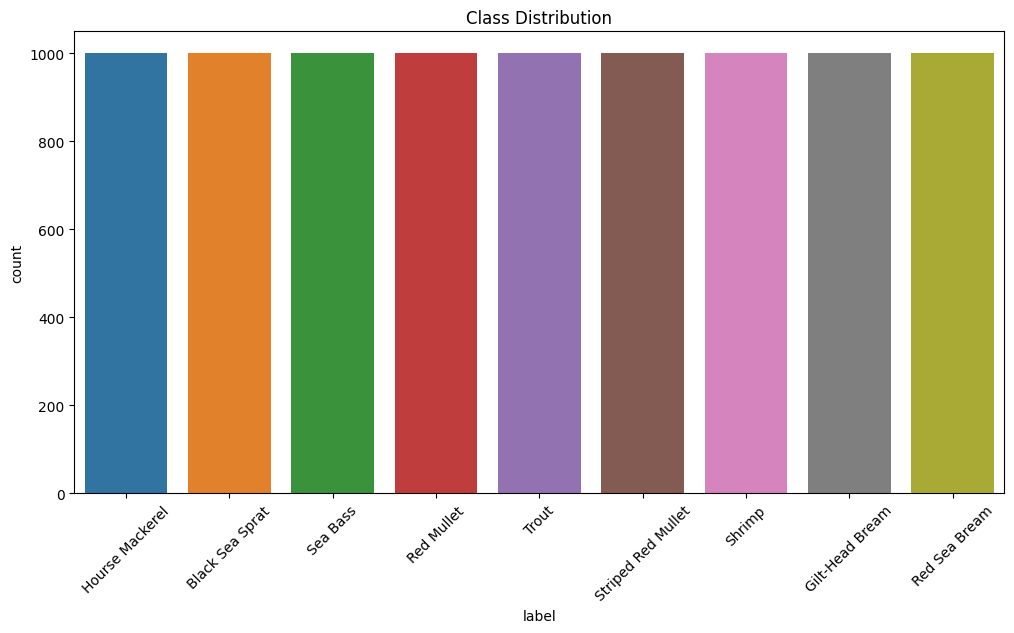

In [6]:
plt.figure(figsize=(12,6))
sns.countplot(x='label', data=data) # x: Classes
plt.xticks(rotation=45)
plt.title('Class Distribution')
plt.show()

This graph allows us to see the class balance in the data set.

We used `ImageDataGenerator` to normalize the images. 
We sized the images with the `target_size` parameter.
Also, GT segmentation images consist of values `0` and `1`. By taking images with more than 2 unique values, we filter out the GTs and use real fish images.

In [7]:
# Data loading and preprocessing function
def load_and_preprocess_data(fish_dir, img_height, img_width):
    datagen = ImageDataGenerator(rescale=1./255)
   
    generator = datagen.flow_from_directory(
        fish_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    
    images, labels = [], []
    for i in range(len(generator)):
        batch = next(generator)

        for index, image in enumerate(batch[0]):
            num_unique_values = len(np.unique(image))
            if num_unique_values > 2:
                images.append(image)
                labels.append(batch[1][index])
                
        if (i + 1) * 32 >= generator.samples:
            break
    
    X = np.array(images)
    y = np.array(labels)
    print('Got shapes: ', X.shape, y.shape)
    
    X_flat = X.reshape(X.shape[0], -1) # Flatten (converting multidimensional image to 1D vector)
    return X_flat, y

Finally, the images are converted to a 1D vector (flattened) while the image array is passed to the `X_flat` variable. In this way, the data was made to work more effectively on the model.

In [8]:
# Data loading
IMG_HEIGHT, IMG_WIDTH = 128, 128
X, y = load_and_preprocess_data(fish_dir, IMG_HEIGHT, IMG_WIDTH)

Found 18000 images belonging to 9 classes.
Got shapes:  (9000, 128, 128, 3) (9000, 9)


Data is split into 80% training and 20% validation.

`random_state`: Fixed to obtain repeatable results.

In [9]:
# Splitting Data into Training and Test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

The training set is scaled using `StandardScaler()`. Scales the data so that its mean is 0 and its standard deviation is 1.

The test set is scaled according to the training set.

In [10]:
# Data Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_val)

In [11]:
print('X_train shape:', X_train_scaled.shape)
print('X_test shape:', X_test_scaled.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_val.shape)

X_train shape: (7200, 49152)
X_test shape: (1800, 49152)
y_train shape: (7200, 9)
y_test shape: (1800, 9)


# **🧠 Build Model**

In this section, the ANN model is created. First, the size of the input layer (`input_shape`) and the number of classes (`num_classes`) are calculated. Then, using the Sequential model architecture, the following layers are added:

1. **`Input Layer:`** Input layer determines the format of the input data.

1. **`Dense Layers:`** 4 Dense layers have 1024, 512, 256 and 128 distributions. In each layer, `ReLU`activation function is used.

1. **`Normalization Layers:`** `BatchNormalization` layers are added after each `Dense` layer. Batch normalization has to continue the previous depth learning thanks to the layers in the network. It provides the opportunity to run simultaneously. It speeds up our training.

1. **`Dropout Layers:`** Dropout layers are added after the Dense layer at a rate of 50% to prevent overfitting.

1. **`Output Layer:`** Finally, there is a Dense layer that is as long as the number of classes and uses the `Softmax` activation function.

In [12]:
# Build ANN Model
input_shape = X_train_scaled.shape[1]
num_classes = y_train.shape[1]

model = Sequential([
    Input(shape=(input_shape,)),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [13]:
# Model Optimization
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,030,537 (194.67 MB)

 Trainable params: 51,026,697 (194.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

`EarlyStopping` and `ReduceLROnPlateau` callbacks are created. 
Early Stopping will stop training if the validation loss does not improve during training. 
Learning Rate Reduction will reduce the learning rate if the validation loss does not improve.

In [15]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

The model is trained using the `model.fit()` method. Training is done in 32 batches over 80 epochs. The validation set is used as 20% of the training set and callbacks are also run during training.

In [16]:
# Model Training
history = model.fit(
    X_train_scaled, y_train,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/80


I0000 00:00:1729604053.012387     116 service.cc:145] XLA service 0x7811240065d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729604053.012451     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 18/180 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1065 - loss: 3.4622

I0000 00:00:1729604060.518462     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.2012 - loss: 2.7884 - val_accuracy: 0.4688 - val_loss: 1.5172 - learning_rate: 0.0010
Epoch 2/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3685 - loss: 1.8828 - val_accuracy: 0.6090 - val_loss: 1.0507 - learning_rate: 0.0010
Epoch 3/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4786 - loss: 1.4669 - val_accuracy: 0.7208 - val_loss: 0.8332 - learning_rate: 0.0010
Epoch 4/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5867 - loss: 1.1415 - val_accuracy: 0.7972 - val_loss: 0.6018 - learning_rate: 0.0010
Epoch 5/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6771 - loss: 0.9153 - val_accuracy: 0.8625 - val_loss: 0.4273 - learning_rate: 0.0010
Epoch 6/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7429 - loss: 0.7539 - val_accuracy: 0.8861 - val_loss: 0.3411 - learning_rate: 0.0010
Epoch 7/80
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7996 - loss: 0.6211 - val

# **🎯 Evaluation & Visualization 📈**

The trained model is evaluated on the test set. Using the `model.evaluate()` method, test loss and test accuracy are calculated. Finally, the test accuracy is printed on the screen.

In [17]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_val)
print(f"Test accuracy: {test_accuracy:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9762 - loss: 0.0640
Test accuracy: 0.9800


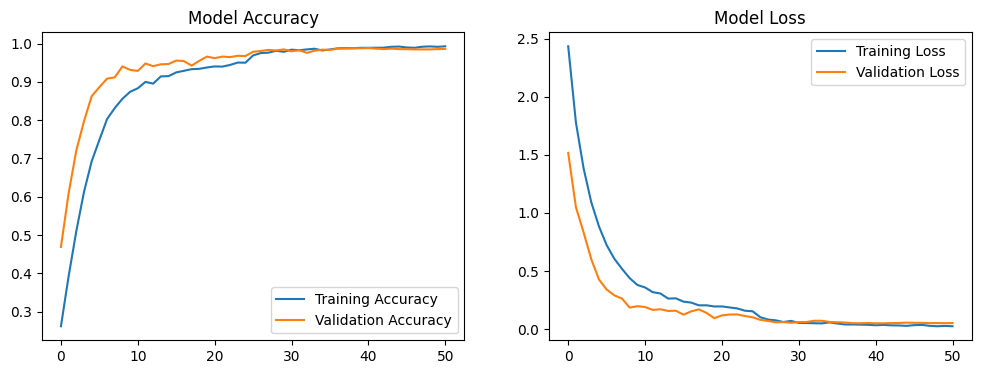

In [18]:
# The graph of the accuracy and loss functions between iterations.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [19]:
# Making Predictions Function
def make_predictions(model, X_test_scaled):
    predictions = model.predict(X_test_scaled)  # Making predictions on test data
    return np.argmax(predictions, axis=1)  # Taking the class with the highest probability for each prediction

In [20]:
# Confusion Matrix Analysis
def plot_confusion_matrix(y_true, y_pred, class_labels):
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Visualizing the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


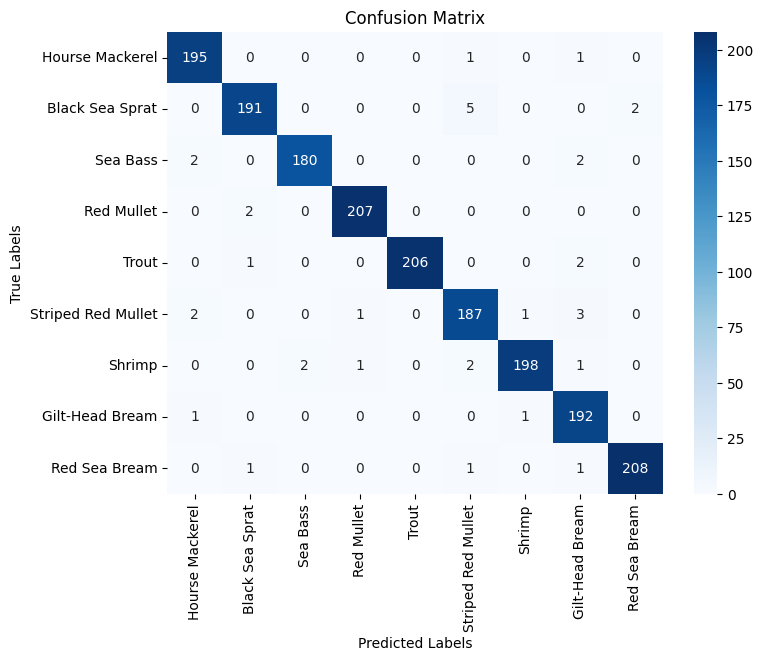

In [21]:
# Making Prediction 
y_pred = make_predictions(model, X_test_scaled)

# Reducing correct predictions to class indices
y_true = np.argmax(y_val, axis=1)

# Create Confusion Matrix
plot_confusion_matrix(y_true, y_pred, class_labels=classes)

In [22]:
# Class Based Performance Analysis
print(classification_report(y_true, y_pred, target_names=classes))

                    precision    recall  f1-score   support

   Hourse Mackerel       0.97      0.99      0.98       197
   Black Sea Sprat       0.98      0.96      0.97       198
          Sea Bass       0.99      0.98      0.98       184
        Red Mullet       0.99      0.99      0.99       209
             Trout       1.00      0.99      0.99       209
Striped Red Mullet       0.95      0.96      0.96       194
            Shrimp       0.99      0.97      0.98       204
   Gilt-Head Bream       0.95      0.99      0.97       194
     Red Sea Bream       0.99      0.99      0.99       211

          accuracy                           0.98      1800
         macro avg       0.98      0.98      0.98      1800
      weighted avg       0.98      0.98      0.98      1800



In [23]:
# Random Prediction Visualizations Function
def plot_random_predictions(X_test_scaled, y_test, y_pred, num_samples):
    num_cols = 5  
    num_rows = num_samples // num_cols if num_samples % num_cols == 0 else (num_samples // num_cols) + 1

    random_indices = np.random.choice(len(X_test_scaled), num_samples, replace=False)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3), subplot_kw={'xticks': [], 'yticks': []})

    for i, idx in enumerate(random_indices):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        ax.imshow(X_test_scaled[idx].reshape(IMG_HEIGHT, IMG_WIDTH, 3))
        true_label = classes[np.argmax(y_test[idx])]
        predicted_label = classes[y_pred[idx]]

        # If the guess is correct set the title to be green and red if it is incorrect
        color = 'green' if true_label == predicted_label else 'red'

        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

    plt.tight_layout()
    plt.show()

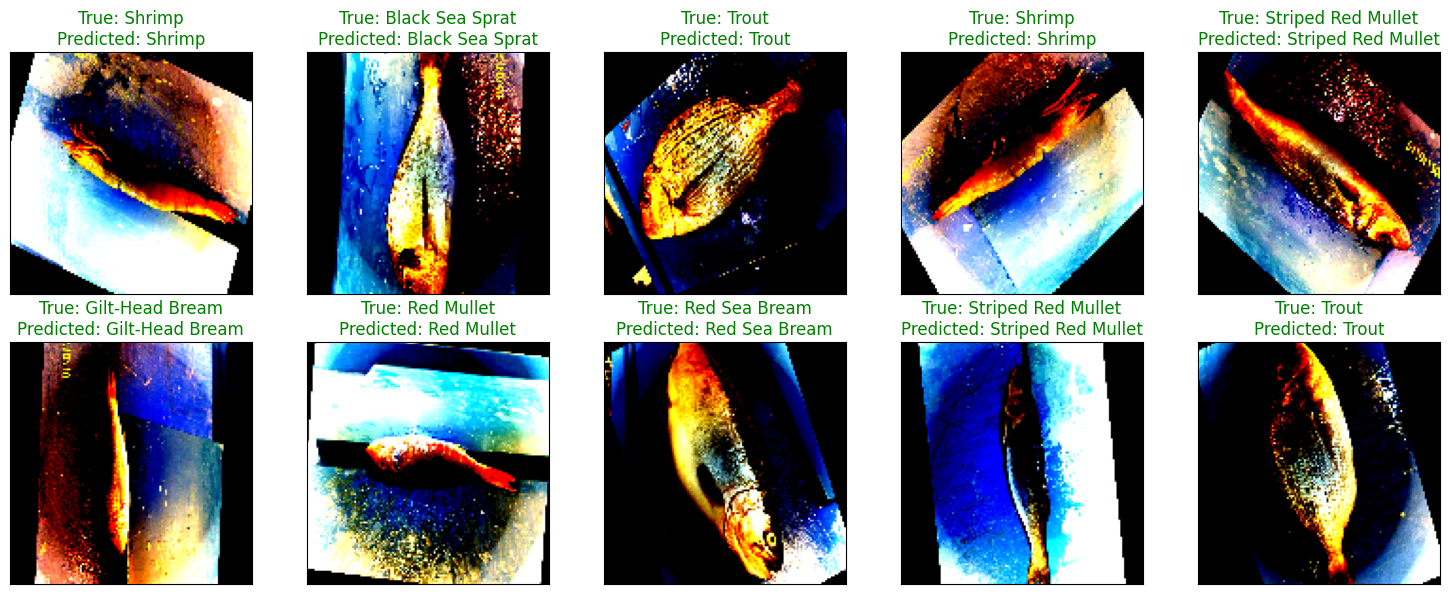

In [24]:
# Random Prediction Visualizations
plot_random_predictions(X_test_scaled, y_val, y_pred, num_samples=10)